# Reading groundwater observations from DINOLoket

This notebook introduces how to use the `hydropandas` package to read, process and visualise groundwater data.

## <a id=top></a>Notebook contents

1. [GroundwaterObs](#GroundwaterObs)
2. [ObsCollection](#ObsCollection)
3. [Reading ObsCollections](#readingOC)

In [1]:
import hydropandas as hpd
import logging
from IPython.display import HTML

import logging

In [2]:
logging.basicConfig(level=logging.INFO)

## GroundwaterObs<a id=GroundwaterObs></a>

The hydropandas package has several functions to read groundwater observations at a measurement well. These include reading data from:
- dino (from csv-files or using the dinoloket api).
- wiski (dumps from the wiski database)

In [3]:
# reading a dino csv file
fname = '../tests/data/2019-Dino-test/Grondwaterstanden_Put/B33F0080001_1.csv'
gw = hpd.GroundwaterObs.from_dino(fname=fname)

INFO:hydropandas.io.io_dino:reading -> B33F0080001_1.csv


In [4]:
# Dino WSDL API is down since January 2021, hopefully something new will arrive soon!

# reading the same data using the DINO api 
# gw = hpd.GroundwaterObs.from_dino(location='B33F0080') 

Now we have an `GroundwaterObs` object named `gw`. This object contains all the available information of measurement well 'B33F0080' and filternumber 1. A `GroundwaterObs` object inherits from a pandas `DataFrame` and has the same attributes and methods.

In [5]:
gw

,metadata
name,B33F0080-001
x,213260.0
y,473900.0
filename,../tests/data/2019-Dino-test/Grondwaterstanden...
locatie,B33F0080
filternr,1.0
bovenkant_filter,3.85
onderkant_filter,2.85
maaiveld,6.92
meetpunt,7.18


In [6]:
print(gw.columns)

Index(['locatie', 'filternummer', 'stand_cm_tov_mp', 'stand_cm_tov_mv',
       'stand_cm_tov_nap', 'bijzonderheid', 'opmerking', 'stand_m_tov_nap',
       'meetpunt', 'maaiveld'],
      dtype='object')


In [7]:
gw.describe()

,filternummer,stand_cm_tov_mp,stand_cm_tov_mv,stand_cm_tov_nap,bijzonderheid,stand_m_tov_nap,meetpunt,maaiveld
count,3988.0,3988.000000,3988.000000,3988.000000,0.0,3988.000000,3988.000000,3988.000000
mean,1.0,158.580742,132.323972,558.722919,NaN,5.587229,7.173037,6.910469
std,0.0,19.048715,19.262626,19.092049,NaN,0.190920,0.021653,0.024010
min,1.0,78.000000,52.000000,490.000000,NaN,4.900000,7.090000,6.850000
25%,1.0,146.000000,120.000000,546.000000,NaN,5.460000,7.180000,6.920000
50%,1.0,159.000000,133.000000,559.000000,NaN,5.590000,7.180000,6.920000
75%,1.0,172.000000,146.000000,571.000000,NaN,5.710000,7.180000,6.920000
max,1.0,226.000000,202.000000,640.000000,NaN,6.400000,7.180000,6.920000


In [8]:
gw

,metadata
name,B33F0080-001
x,213260.0
y,473900.0
filename,../tests/data/2019-Dino-test/Grondwaterstanden...
locatie,B33F0080
filternr,1.0
bovenkant_filter,3.85
onderkant_filter,2.85
maaiveld,6.92
meetpunt,7.18


<AxesSubplot:ylabel='m NAP'>

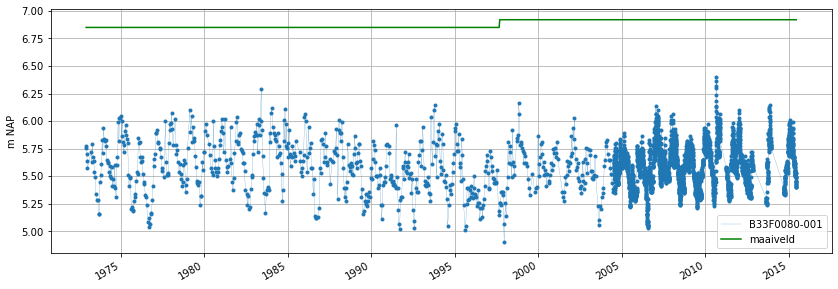

In [9]:
ax = gw['stand_m_tov_nap'].plot(label=gw.name, figsize=(14,5), legend=True,
                                marker='.', lw=0.2)
gw['maaiveld'].plot(ax=ax, label='maaiveld', legend=True, grid=True, color='green',ylabel='m NAP')


#### GroundwaterObs Attributes

Besides the standard `DataFrame` attributes a `GroundwaterObs` has the following additional attributes:
- x, y: x- and y-coordinates of the observation point
- name: str with the name
- filename: str with the filename (only available when the data was loaded from a file)
- locatie: the name for the location of the observation point.
- filternr: the number of the filter. The combination of locatie and filternr should be unique
- bovenkant_filter: the top of the filter
- onderkant_filter: the bottom of the filter
- maaiveld: surface level
- meetpunt: the top of the well
- metadata_available: boolean indicating whether metadata is available for this observation point
- meta: dictionary with additional metadata

When dowloading from Dinoloket all levels are in meters NAP.

In [10]:
print(f'x = {gw.x}')
print(f'y = {gw.y}')
print(f'name = {gw.name}')
print(f'filename = {gw.filename}')
print(f'locatie = {gw.locatie}')
print(f'filternr = {gw.filternr}')
print(f'bovenkant_filter = {gw.bovenkant_filter}')
print(f'onderkant_filter = {gw.onderkant_filter}')
print(f'maaiveld = {gw.maaiveld}')
print(f'meetpunt = {gw.meetpunt}')
print(f'metadata_available = {gw.metadata_available}')

print(f'\nmeta = {gw.meta}')

x = 213260.0
y = 473900.0
name = B33F0080-001
filename = ../tests/data/2019-Dino-test/Grondwaterstanden_Put/B33F0080001_1.csv
locatie = B33F0080
filternr = 1.0
bovenkant_filter = 3.85
onderkant_filter = 2.85
maaiveld = 6.92
meetpunt = 7.18
metadata_available = True

meta = {'locatie': 'B33F0080', 'x': 213260.0, 'y': 473900.0, 'filternr': 1.0, 'meetpunt': 7.18, 'bovenkant_filter': 3.85, 'onderkant_filter': 2.85, 'maaiveld': 6.92, 'name': 'B33F0080-001', 'metadata_available': True, 'filename': '../tests/data/2019-Dino-test/Grondwaterstanden_Put/B33F0080001_1.csv'}


#### GroundwaterObs methods

Besides the standard `DataFrame` methods a `GroundwaterObs` has additional methods. This methods are accessible through submodules:
- `geo.get_lat_lon()`, to obtain latitude and longitude
- `gwobs.get_modellayer()`, to obtain the modellayer of a modflow model using the filter depth
- `stats.get_seasonal_stat()`, to obtain seasonal statistics
- `stats.obs_per_year()`, to obtain the number of observations per year
- `stats.consecutive_obs_years()`, to obtain the number of consecutive years with more than a minimum number of observations
- `plots.interactie_plot()`, to obtain a bokeh plot





Get latitude and longitude with `gw.geo.get_lat_lon()`:

In [11]:
print(f'latitude and longitude -> {gw.geo.get_lat_lon()}')

latitude and longitude -> (52.250058043935184, 6.240361082512327)


In [12]:
gw.stats.get_seasonal_stat(stat="mean")

,winter_mean,summer_mean
B33F0080-001,5.694514,5.489309


In [13]:
p= gw.plots.interactive_plot('figure')
HTML(filename="figure/{}.html".format(gw.name))

## ObsCollections<a id=ObsCollections></a>

`ObsCollections` are a combination of multiple observation objects such as `GroundwaterObs` objects. The easiest way to construct an `ObsCollections` is from a list of observation objects.

In [14]:
fname1 = '../tests/data/2019-Dino-test/Grondwaterstanden_Put/B33F0080001_1.csv'
fname2 = '../tests/data/2019-Dino-test/Grondwaterstanden_Put/B33F0133001_1.csv'
gw1 = hpd.GroundwaterObs.from_dino(fname=fname1)
gw2 = hpd.GroundwaterObs.from_dino(fname=fname2)

# create ObsCollection
oc = hpd.ObsCollection.from_list([gw1, gw2], name='Dino groundwater')
oc

INFO:hydropandas.io.io_dino:reading -> B33F0080001_1.csv
INFO:hydropandas.io.io_dino:reading -> B33F0133001_1.csv


,x,y,filename,locatie,filternr,bovenkant_filter,onderkant_filter,maaiveld,meetpunt,metadata_available,obs
name,,,,,,,,,,,
B33F0080-001,213260.0,473900.0,../tests/data/2019-Dino-test/Grondwaterstanden...,B33F0080,1.0,3.85,2.85,6.92,7.18,True,-----metadata------ name : B33F0080-001 x : 2...
B33F0133-001,210400.0,473366.0,../tests/data/2019-Dino-test/Grondwaterstanden...,B33F0133,1.0,-67.50,-70.00,6.50,7.14,True,-----metadata------ name : B33F0133-001 x : 2...


Now we have an `ObsCollection` object named `oc`. The `ObsCollection` contains all the data from the two `GroundwaterObs` objects. It also stores a reference to the `GroundwaterObs` objects in the 'obs' column. Just like a `GroundwaterObs` object and `ObsCollection` object inherits from a pandas `DataFrame` and has the same attributes and methods.

In [15]:
# get columns
oc.columns

Index(['x', 'y', 'filename', 'locatie', 'filternr', 'bovenkant_filter',
       'onderkant_filter', 'maaiveld', 'meetpunt', 'metadata_available',
       'obs'],
      dtype='object')

In [16]:
# get statistics
oc.describe()

,x,y,filternr,bovenkant_filter,onderkant_filter,maaiveld,meetpunt
count,2.000000,2.000000,2.0,2.000000,2.000000,2.000000,2.000000
mean,211830.000000,473633.000000,1.0,-31.825000,-33.575000,6.710000,7.160000
std,2022.325394,377.595021,0.0,50.452069,51.512729,0.296985,0.028284
min,210400.000000,473366.000000,1.0,-67.500000,-70.000000,6.500000,7.140000
25%,211115.000000,473499.500000,1.0,-49.662500,-51.787500,6.605000,7.150000
50%,211830.000000,473633.000000,1.0,-31.825000,-33.575000,6.710000,7.160000
75%,212545.000000,473766.500000,1.0,-13.987500,-15.362500,6.815000,7.170000
max,213260.000000,473900.000000,1.0,3.850000,2.850000,6.920000,7.180000


In [17]:
# get individual GroundwaterObs object from an ObsCollection
o = oc.loc['B33F0133-001', 'obs']
o

,metadata
name,B33F0133-001
x,210400.0
y,473366.0
filename,../tests/data/2019-Dino-test/Grondwaterstanden...
locatie,B33F0133
filternr,1.0
bovenkant_filter,-67.5
onderkant_filter,-70.0
maaiveld,6.5
meetpunt,7.14


#### ObsCollection Attributes

An `ObsCollection` also has additional attributes:
- name, a str with the name of the collection
- meta, a dictionary with additional metadata

In [18]:
print(f'name is -> {oc.name}')
print(f'meta is -> {oc.meta}')

name is -> Dino groundwater
meta is -> {}


#### ObsCollection methods
Besides the methods of a pandas `DataFrame` an `ObsCollection` has additional methods stored in submodules.

`geo`:
- `get_bounding_box` -> get a tuple with (xmin, ymin, xmax, ymax)
- `get_extent` -> get a tule with (xmin, xmax, ymin, ymax)
- `get_lat_lon` -> to get the lattitudes and longitudes from the x and y coördinates
- `within_polygon` -> to select only the observations that lie within a polygon

`gwobs`:
- `set_filter_num` -> to set the filternumbers based on the filter depth when there are multiple filters at one location
- `set_filter_num_location` -> find out which observations are at the same location with a different filter depth. Set locatie and filternr attributes accordingly.

`plots`:
- `interactive_figures` -> create bokeh figures for each observation point.
- `interactive_map` -> create a folium map with observation points and bokeh figures for each observation point.

`stats`:
- `get_first_last_obs_date()` -> get the first and the last date of the observations for each observation point
- `get_no_of_observations()` -> get the number of observations
- `get_seasonal_stat()` -> get seasonal stats of the observations

E.g. get the bounding box with `gw.geo.get_lat_lon()`:

In [19]:
print(f'bounding box -> {oc.geo.get_bounding_box()}')

bounding box -> (210400.0, 473366.0, 213260.0, 473900.0)


In [20]:
oc.geo.set_lat_lon()
oc.plots.interactive_map(plot_dir='figure')

INFO:hydropandas.obs_collection:set B33F0080-001, lat to 52.250058043935184
INFO:hydropandas.obs_collection:add lat of B33F0080-001 with value 52.250058043935184 to meta
INFO:hydropandas.obs_collection:set B33F0080-001, lon to 6.240361082512327
INFO:hydropandas.obs_collection:add lon of B33F0080-001 with value 6.240361082512327 to meta
INFO:hydropandas.obs_collection:set B33F0133-001, lat to 52.24555403894194
INFO:hydropandas.obs_collection:add lat of B33F0133-001 with value 52.24555403894194 to meta
INFO:hydropandas.obs_collection:set B33F0133-001, lon to 6.198395981105792
INFO:hydropandas.obs_collection:add lon of B33F0133-001 with value 6.198395981105792 to meta
INFO:hydropandas.extensions.plots:created iplot -> B33F0080-001
INFO:hydropandas.extensions.plots:created iplot -> B33F0133-001


## Reading ObsCollections<a id=readingOC></a>

Instead of creating the ObsCollection from a list of observation objects. It is also possible to read the data from a source into an ObsCollection at once. The following sources can be read as an ObsCollection:

- dino (from files or the dinoloket API)
- fews (dumps from the fews database)
- wiski (dumps from the wiski database)
- arctic (a Mongo database for timeseries)
- menyanthes (a .men file)
- modflow (from the heads of a modflow model)
- imod (from the heads of an imod model)

This notebook won't go into detail on all the sources that can be read. Only the two options for reading data from Dinoloket are shown below.

In [21]:
# Dino WSDL API is down since January 2021, hopefully something new will arrive soon!

# read using the DINO api
# extent = [117850, 117980, 439550, 439700]  # Schoonhoven zuid-west
# dino_gw = hpd.ObsCollection.from_dino(extent=extent, keep_all_obs=False, cache=True)
# dino_gw

In [22]:
# read using a .zip file with data
dinozip = '../tests/data/2019-Dino-test/dino.zip'
dino_gw = hpd.ObsCollection.from_dino(dirname=dinozip, keep_all_obs=False)
dino_gw

INFO:hydropandas.io.io_dino:reading -> B02H0092001_1.csv
INFO:hydropandas.io.io_dino:reading -> B02H1007001_1.csv
INFO:hydropandas.io.io_dino:reading -> B04D0032002_1.csv
INFO:root:not added to collection -> C:\Users\oebbe\AppData\Local\Temp\tmp7y_bkmpa\Grondwaterstanden_Put\B04D0032002_1.csv
INFO:hydropandas.io.io_dino:reading -> B22D0155001_1.csv
INFO:hydropandas.io.io_dino:reading -> B27D0260001_1.csv
INFO:root:not added to collection -> C:\Users\oebbe\AppData\Local\Temp\tmp7y_bkmpa\Grondwaterstanden_Put\B27D0260001_1.csv
INFO:hydropandas.io.io_dino:reading -> B33F0080001_1.csv
INFO:hydropandas.io.io_dino:reading -> B33F0080002_1.csv
INFO:hydropandas.io.io_dino:reading -> B33F0133001_1.csv
INFO:hydropandas.io.io_dino:reading -> B33F0133002_1.csv
INFO:hydropandas.io.io_dino:reading -> B37A0112001_1.csv
INFO:root:not added to collection -> C:\Users\oebbe\AppData\Local\Temp\tmp7y_bkmpa\Grondwaterstanden_Put\B37A0112001_1.csv
INFO:hydropandas.io.io_dino:reading -> B42B0003001_1.csv
INFO

,x,y,filename,locatie,filternr,bovenkant_filter,onderkant_filter,maaiveld,meetpunt,metadata_available,obs
name,,,,,,,,,,,
B02H0092-001,219890.0,600030.0,C:\Users\oebbe\AppData\Local\Temp\tmp7y_bkmpa\...,B02H0092,1.0,NaN,NaN,NaN,NaN,True,-----metadata------ name : B02H0092-001 x : 2...
B02H1007-001,219661.0,600632.0,C:\Users\oebbe\AppData\Local\Temp\tmp7y_bkmpa\...,B02H1007,1.0,NaN,NaN,1.92,NaN,True,-----metadata------ name : B02H1007-001 x : 2...
B22D0155-001,233830.0,502530.0,C:\Users\oebbe\AppData\Local\Temp\tmp7y_bkmpa\...,B22D0155,1.0,7.80,6.80,8.91,9.94,True,-----metadata------ name : B22D0155-001 x : 2...
B33F0080-001,213260.0,473900.0,C:\Users\oebbe\AppData\Local\Temp\tmp7y_bkmpa\...,B33F0080,1.0,3.85,2.85,6.92,7.18,True,-----metadata------ name : B33F0080-001 x : 2...
B33F0080-002,213260.0,473900.0,C:\Users\oebbe\AppData\Local\Temp\tmp7y_bkmpa\...,B33F0080,2.0,-10.15,-12.15,6.92,7.17,True,-----metadata------ name : B33F0080-002 x : 2...
B33F0133-001,210400.0,473366.0,C:\Users\oebbe\AppData\Local\Temp\tmp7y_bkmpa\...,B33F0133,1.0,-67.50,-70.00,6.50,7.14,True,-----metadata------ name : B33F0133-001 x : 2...
B33F0133-002,210400.0,473366.0,C:\Users\oebbe\AppData\Local\Temp\tmp7y_bkmpa\...,B33F0133,2.0,-104.20,-106.20,6.50,7.12,True,-----metadata------ name : B33F0133-002 x : 2...
B42B0003-001,38165.0,413785.0,C:\Users\oebbe\AppData\Local\Temp\tmp7y_bkmpa\...,B42B0003,1.0,-2.00,-3.00,6.50,6.99,True,-----metadata------ name : B42B0003-001 x : 3...
B42B0003-002,38165.0,413785.0,C:\Users\oebbe\AppData\Local\Temp\tmp7y_bkmpa\...,B42B0003,2.0,-34.00,-35.00,6.50,6.99,True,-----metadata------ name : B42B0003-002 x : 3...
